In [1]:
import torch
import numpy as np

import torch_geometric.transforms as T

from sklearn.metrics import roc_auc_score, average_precision_score

%matplotlib inline
import matplotlib.pyplot as plt
from latent.utils import draw_samples_2d
from latent.models import VGAE, Encoder, InnerProductDecoder, InnerProductDecoderBasis, MLPDecoder

In [2]:
from torch_geometric.datasets import Planetoid

transform = T.Compose([T.NormalizeFeatures(), T.ToDevice('cuda')])

dataset = Planetoid("data/", "CiteSeer", transform=transform)

split = T.RandomLinkSplit(0.05, 0.1, is_undirected=True)
train_data, val_data, test_data = split(dataset[0])
train_data.edge_label = train_data.edge_label_index = None

train_data, val_data, test_data

/home/anthony/.local/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


(Data(x=[3327, 3703], edge_index=[2, 7740], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327]),
 Data(x=[3327, 3703], edge_index=[2, 7740], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[454], edge_label_index=[2, 454]),
 Data(x=[3327, 3703], edge_index=[2, 8194], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[910], edge_label_index=[2, 910]))

In [3]:
num_features = dataset.data.num_features

device = torch.device('cuda')
encoder = Encoder(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=2,
    num_layers=2
)
decoder = InnerProductDecoder()
# decoder = InnerProductDecoderBasis(hidden_channels=512)
# decoder = MLPDecoder(hidden_channels=2)

vgae = VGAE(
    encoder=encoder,
    decoder=decoder,
    lambda1=8.0,
    lambda2=1.0
)
vgae = vgae.to(device)
optimizer = torch.optim.Adam(vgae.parameters(), lr=0.01)

vgae

VGAE(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): GCNConv(3703, 64)
    )
    (conv_mu): GCNConv(64, 2)
    (conv_logstd): GCNConv(64, 2)
  )
  (decoder): InnerProductDecoder()
  (bce_loss): BCELoss()
)

In [4]:
def train(model, train_data):
    model.train()
    optimizer.zero_grad()

    z, mu, logstd = model.encode(train_data.x, train_data.edge_index)
    y_pred = model.decode(z, train_data.edge_label_index)
    
    recon_loss = model.recon_loss(y_pred, train_data.edge_label)
    dkl_loss = model.dkl_loss(mu, logstd)
    loss = recon_loss + dkl_loss

    loss.backward()
    optimizer.step()

    return float(loss), float(recon_loss), float(dkl_loss)

@torch.no_grad()
def test(model, val_data):
    model.eval()

    z, _, _ = model.encode(val_data.x, val_data.edge_index)
    y_pred = model.decode(z, val_data.edge_label_index)
    
    y_true, y_pred = val_data.edge_label.cpu().numpy(), y_pred.cpu().numpy()

    return roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred)

In [5]:
num_epochs = 1000
split = T.RandomLinkSplit(0.15, 0.0, is_undirected=True)

for epoch in range(num_epochs):
    train_split, _, _ = split(train_data)

    train_loss = train(vgae, train_split)
    roc_auc, ap = test(vgae, val_data)

    if epoch % 10 == 0:
        print('Epoch {:04d}: train_loss: ({:.4f}; {:.4f}; {:.4f}); ROC_AUC: {:.4f}; AP: {:.4f}'
                .format(epoch, *train_loss, roc_auc, ap))

Epoch 0000: train_loss: (1.5569; 1.5569; 0.0000); ROC_AUC: 0.6185; AP: 0.6522
Epoch 0010: train_loss: (1.3904; 1.2618; 0.1286); ROC_AUC: 0.5687; AP: 0.6047
Epoch 0020: train_loss: (1.3656; 1.3151; 0.0505); ROC_AUC: 0.6272; AP: 0.6614
Epoch 0030: train_loss: (1.3626; 1.2980; 0.0646); ROC_AUC: 0.5656; AP: 0.5909
Epoch 0040: train_loss: (1.3549; 1.2864; 0.0685); ROC_AUC: 0.7221; AP: 0.7348
Epoch 0050: train_loss: (1.3593; 1.2961; 0.0632); ROC_AUC: 0.7271; AP: 0.7412
Epoch 0060: train_loss: (1.3694; 1.3037; 0.0657); ROC_AUC: 0.6967; AP: 0.7254
Epoch 0070: train_loss: (1.3441; 1.2779; 0.0663); ROC_AUC: 0.6685; AP: 0.7143
Epoch 0080: train_loss: (1.3290; 1.2495; 0.0795); ROC_AUC: 0.7198; AP: 0.7509
Epoch 0090: train_loss: (1.2734; 1.1703; 0.1031); ROC_AUC: 0.8096; AP: 0.8243
Epoch 0100: train_loss: (1.2568; 1.1218; 0.1350); ROC_AUC: 0.8225; AP: 0.8371
Epoch 0110: train_loss: (1.2498; 1.1119; 0.1379); ROC_AUC: 0.8272; AP: 0.8375
Epoch 0120: train_loss: (1.2182; 1.0712; 0.1470); ROC_AUC: 0.827

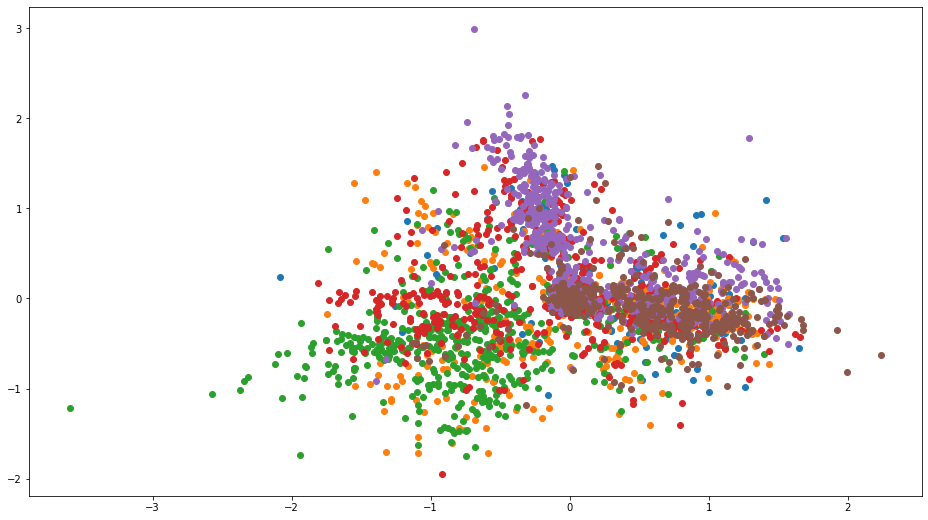

In [6]:
with torch.no_grad():
    z, _, _ = vgae.encode(test_data.x, test_data.edge_index)

draw_samples_2d(z.cpu().numpy(), test_data.y.cpu().numpy())

5331921 5737008


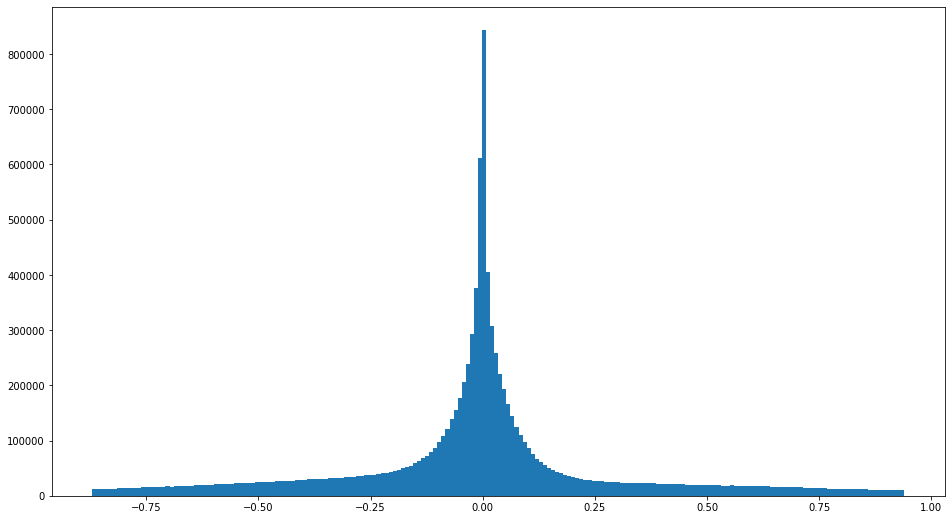

In [7]:
with torch.no_grad():
    z, _, _ = vgae.encode(test_data.x, test_data.edge_index)
    adj = vgae.decoder.forward_all(z, sigmoid=False)
    adj = adj.cpu().numpy()

print((adj > 0.0).sum(), (adj <= 0.0).sum())

plt.figure(figsize=(16, 9))
perc1 = np.percentile(adj, 5)
perc2 = np.percentile(adj, 95)

mask = (adj.ravel() > perc1) & (adj.ravel() < perc2)

_ = plt.hist(adj.ravel()[mask], bins=200)